# Graph of Convex Sets (GCS) and Iterative Region Inflation by Semidefinite Programming (IRIS)

In this exercise, you will practice finding large collision-free configuration-space regions with IRIS and planning through them with GCS for the Kuka Iiwa manipulator. We highly recommend reading through [Section 6.4](https://manipulation.csail.mit.edu/trajectories.html#gcs) of the textbook and looking through the example problems.

It will be helpful to keep the Drake documentation (C++ version as first reference, Python as secondary) handy as well as we'll be working with its builtin IRIS and GCS functionality.

In [1]:
import time
from typing import List

import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.all import (
    AddDefaultVisualization,
    AddMultibodyPlantSceneGraph,
    CompositeTrajectory,
    Context,
    Diagram,
    DiagramBuilder,
    GraphOfConvexSets,
    GraphOfConvexSetsOptions,
    HPolyhedron,
    InverseKinematics,
    IrisInConfigurationSpace,
    IrisOptions,
    LoadIrisRegionsYamlFile,
    MathematicalProgram,
    MultibodyPlant,
    Parser,
    Point,
    Rgba,
    RigidBodyFrame,
    RigidTransform,
    SaveIrisRegionsYamlFile,
    Solve,
    Sphere,
    StartMeshcat,
)
from pydrake.planning import GcsTrajectoryOptimization

from manipulation import running_as_notebook
from manipulation.meshcat_utils import PublishPositionTrajectory
from manipulation.scenarios import AddIiwa, AddWsg
from manipulation.utils import ConfigureParser

np.random.seed(42)  # for reproducibility

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
iris_filepath = "iris_regions.yaml"

### Helper methods to visualize IRIS region

This function enabales you to visualize IRIS regions by having the Kuka Iiwa robot trace out the boundaries of the space represented in the IRIS region. This is a great debugging tool to understand what regions of space are included in your IRIS regions later on.


In [4]:
def AnimateIris(
    root_diagram: Diagram,
    root_context: Context,
    plant: MultibodyPlant,
    region: HPolyhedron,
    speed: float,
) -> None:
    """
    A simple hit-and-run-style idea for visualizing the IRIS regions:
    1. Start at the center. Pick a random direction and run to the boundary.
    2. Pick a new random direction; project it onto the current boundary, and run along
       it. Repeat
    """

    plant_context = plant.GetMyContextFromRoot(root_context)

    q = region.ChebyshevCenter()
    plant.SetPositions(plant_context, q)
    root_diagram.ForcedPublish(root_context)

    print("Press the 'Stop Animation' button in Meshcat to continue.")
    meshcat.AddButton("Stop Animation", "Escape")

    rng = np.random.default_rng()
    nq = plant.num_positions()
    prog = MathematicalProgram()
    qvar = prog.NewContinuousVariables(nq, "q")
    prog.AddLinearConstraint(region.A(), 0 * region.b() - np.inf, region.b(), qvar)
    cost = prog.AddLinearCost(np.ones((nq, 1)), qvar)

    while meshcat.GetButtonClicks("Stop Animation") < 1:
        direction = rng.standard_normal(nq)
        cost.evaluator().UpdateCoefficients(direction)

        result = Solve(prog)
        assert result.is_success()

        q_next = result.GetSolution(qvar)

        # Animate between q and q_next (at speed):
        # TODO: normalize step size to speed... e.g. something like
        # 20 * np.linalg.norm(q_next - q) / speed
        for t in np.append(np.arange(0, 1, 0.05), 1):
            qs = t * q_next + (1 - t) * q
            plant.SetPositions(plant_context, qs)
            root_diagram.ForcedPublish(root_context)
            if running_as_notebook:
                time.sleep(0.05)

        q = q_next

        if not running_as_notebook:
            break

    meshcat.DeleteButton("Stop Animation")

### Helper method to setup new Kuka IIwa diagram



In [5]:
def BuildIiwaWithShelves() -> Diagram:
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    iiwa = AddIiwa(plant)
    wsg = AddWsg(plant, iiwa, welded=True, sphere=False)

    parser = Parser(plant)
    ConfigureParser(parser)
    bin = parser.AddModelsFromUrl("package://manipulation/shelves.sdf")[0]
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetFrameByName("shelves_body", bin),
        RigidTransform([0.88, 0, 0.4]),
    )

    plant.Finalize()
    AddDefaultVisualization(builder, meshcat)

    return builder.Build()

## Creating the IRIS Region


In [6]:
# Clearing our visualization
meshcat.Delete()

In [7]:
# Setting up diagram and plant
diagram = BuildIiwaWithShelves()
context = diagram.CreateDefaultContext()
plant = diagram.GetSubsystemByName("plant")
plant_context = plant.GetMyContextFromRoot(context)

In [10]:
# TODO: get the initial joint positions of your robot (call it q0) and the gripper frame (gripper_frame)

q0 = plant.GetPositions(plant_context)
gripper_frame = plant.GetFrameByName("body")

print(f"{q0=}, {gripper_frame=}")

q0=array([ 0. ,  0.1,  0. , -1.2,  0. ,  1.6,  0. ]), gripper_frame=<RigidBodyFrame name='body' index=24 model_instance=3>


#### Creating the "home" IRIS region

Now we will create an IRIS region corresponding to the free space around the Kuka Iiwa. Since our shelves enviornment is mostly free space, we want to get an IRIS region representation of this free space. Example 6.12 in the textbook uses this `home_region` to restrict the IRIS region search when mapping out the area in front of and inside the top shelf, so that we don't spend time expanding IRIS regions into space that is obstacle free and therefore trivial to plan through. 

We will not be using the restriction in this exercise, but we'd like you to start by implementing the `home_region` and visualizing it as a low-barrier entry point to the more complex tasks we'll do next as you have a "ground truth" against which to compare your work.

Please refer to [IrisOptions](https://drake.mit.edu/doxygen_cxx/structdrake_1_1geometry_1_1optimization_1_1_iris_options.html) documentation to understand the pre-filled settings. 

Hint: If you're having trouble finding which Drake function will create an IRIS region for you, look up the ones in the imports.

In [13]:
options = IrisOptions()
options.num_collision_infeasible_samples = 3 if running_as_notebook else 1
options.random_seed = 1235
options.require_sample_point_is_contained = True
options.configuration_space_margin = 0.05

# TODO: use IrisInConfigurationSpace to create your home_region
home_region = IrisInConfigurationSpace(plant, plant_context, options)

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake: Checking gripper::collision against shelves::shelf_upper has already required 30 counter-example searches; still searching...
INFO:drake: Finished checking gripper::collision against shelves::shelf_upper after 34 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake: Checking gripper::collision against shelves::shelf_upper has already required 30 counter-example searches; still searching...
INFO:drake: Finished checking gripper::collision against shelves::shelf_upper after 69 counter-example searches.
INFO:drake: Checking gripper::collision against shelves::top has already required 30 counter-example searches; still searching...
INFO:drake: Finished checking gripper::collision against shelves::top after 36 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 3
INFO:drake: Checking gripper::collision against shelves::shelf_upper ha

Run the AnimateIris function below to see your home_region "sketched out" in Meshcat. To stop the visualization, interrupt the cell (using the square stop button beside it) or click 'Stop Animation' in the Meshcat dropdown.

If what you see makes you curious, visit the documentation and linked paper to learn more about how IRIS builds a convex polytope to represent obstacle-free space: https://drake.mit.edu/doxygen_cxx/group__planning__iris.html#gafd8111a93cb3461e05bec3477ee736f6

In [14]:
if running_as_notebook:
    AnimateIris(diagram, context, plant, home_region, 1.0)

Press the 'Stop Animation' button in Meshcat to continue.


#### Creating the shelf regions

Now we will create IRIS regions corresponding to the area in front of the shelf and the top shelf. 

IRIS expands its convex polytopes out of a given sample point and list of convex obstacles. The joint state of our plant in the context that we pass to the `IrisInConfigurationSpace` function is the sample point and the list of convex obstacles is described in the `plant` and `plant_context`. 

So we're not guaranteed, in finite iterations, to include a joint state that corresponds to the desired end effector position, in our `home_region` IRIS region. Therefore, to be sure we include our desired start and end points for our end effector, we will use Inverse Kinematics to get corresponding joint positions and use those as our sample points in building our IRIS regions.

This means you'll be writing two functionalities in this section. First, a reusable function that solves an Inverse Kinematics problem, which you've seen in past PSETs. Second, code to generate IRIS regions, similar to what we completed above, but instead using a scaled down version of the `home_region` as a an obstacle to guide our IRIS region expansion.

**Hint**: this Inverse Kinematics function you'll implement first is very similiar (but slightly different) than the `solve_ik_for_pose` function you wrote in PSET 5's 5_plan_place_initials.ipynb. Refering back to your solution for PSET 5 is good place to start.


In [ ]:
def solve_IK(
    plant: MultibodyPlant,
    plant_context: Context,
    goal_pos: List,
    ee_frame: RigidBodyFrame,
    q_initial: np.ndarray,
) -> np.ndarray | None:
    ik = InverseKinematics(plant, plant_context)
    
    # TODO: add a minimum distance we must keep from all geometries in our environment
    # (this is to prevent collisions)
    # use a minimum distance (aka bound in the Drake function args) of 0.001
    # and an influence_distance_offset of 0.01
    ik.AddMinimumDistanceLowerBoundConstraint(0.001, 0.01)

    # Constrain our end effector (the gripper) to be at the goal position
    ik.AddPositionConstraint(
        ee_frame, [0, 0.1, 0], plant.world_frame(), goal_pos, goal_pos
    )
    
    # TODO: get the joint space variables
    q_vars = ik.q()
    
    # TODO: get the program from your Inverse Kinematics object
    prog = ik.prog()
    
    # TODO: add a distance squared cost on the difference
    # between your initial joint locations and your joint variables
    # Hint: use AddQuadraticErrorCost
    prog.AddQuadraticErrorCost(np.eye(len(q_initial)), q_initial, q_vars)
    
    # TODO: set an initial guess for your IK solve to your initial position
    prog.SetInitialGuess(q_vars, q_initial)
    
    # TODO: solve your IK program
    result = Solve(prog)
    
    if result.is_success():
        return result.GetSolution(q_vars)
    else:
        return None

Now we set the end effector position out of which we'll expand our top shelf's IRIS region, solve for corresponding joint states using our IK helper function above, then call IRIS from our solved joint state. Throughout the IRIS region expansion that follows you may see a few glancing collisions with the shelves in the resulting region. Increase the `num_collision_infeasible_samples` option to reduce them (at the cost of IRIS running for longer, or similarly lower them to run for shorter with the chance of more collisions). The number we've provided is a high estimate that we have made sure works well.

In [16]:
p_TopShelf = [0.95, 0, 0.65]
# TODO: get a solved joint state using your helper function
q_sol = solve_IK(plant, plant_context, p_TopShelf, gripper_frame, q0)

if q_sol is not None:
    # TODO: set the position of our Kuka Iiwa in our
    # plant_context to the solved joint state
    plant.SetPositions(plant_context, q_sol)

    # Now we force our diagram to reflect this change, since IRIS
    # will use the context object to create it's region
    diagram.ForcedPublish(context)

    options = IrisOptions()
    options.num_collision_infeasible_samples = 30
    options.random_seed = 1235
    options.require_sample_point_is_contained = True
    options.configuration_space_margin = 0.05
    # TODO: call IRIS to get your top shelf_region
    shelf_region = IrisInConfigurationSpace(plant, plant_context, options)

else:
    print("IK failed for shelf position")

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the hyperellipsoid volume change 0.0002078524741254851 is below the threshold 0.02.


In [17]:
if running_as_notebook:
    AnimateIris(diagram, context, plant, shelf_region, 1.0)

Press the 'Stop Animation' button in Meshcat to continue.


If you got the `shelf_region` working above, the same approach will work here. In this snippet we're expanding an IRIS region starting from the end effector pose our robot will initialize in. This ensures we get an IRIS region that directly borders/overlaps with our top shelf region. This is critical if we want to be able to use GCS to plan through these regions.

In [18]:
p_Start = [0.75, 0, 0.64]
# TODO: get a solved joint state using your helper function
q_sol = solve_IK(plant, plant_context, p_Start, gripper_frame, q0)

if q_sol is not None:
    # TODO: set the position of our Kuka Iiwa in our
    # plant_context to the solved joint state
    plant.SetPositions(plant_context, q_sol)

    diagram.ForcedPublish(context)

    options = IrisOptions()
    options.num_collision_infeasible_samples = 30
    options.random_seed = 1235
    options.require_sample_point_is_contained = True
    options.configuration_space_margin = 0.05

    # TODO: call IRIS to get your top start_region
    start_region = IrisInConfigurationSpace(plant, plant_context, options)

else:
    print("IK failed for shelf position")
    start_region = home_region  # Fallback

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the hyperellipsoid volume change 0.006306229226426109 is below the threshold 0.02.


In [19]:
if running_as_notebook:
    AnimateIris(diagram, context, plant, start_region, 1.0)

Press the 'Stop Animation' button in Meshcat to continue.


It can take some time (~30 seconds) to create your IRIS regions, so we include this helper code to save your regions to a YAML and load them in. Feel free to just use your saved regions, once you're sure they're right.

In [20]:
iris_regions = {
    "home_region": home_region,
    "start_region": start_region,
    "shelf_region": shelf_region,
}
SaveIrisRegionsYamlFile(iris_filepath, iris_regions)

In [21]:
# We're adding an offset to the position from which we create the IRIS region,
# to illustrate the sort of edge cases GCS is great for planning through once you
# have good IRIS regions. Feel free to play around with these values and push the
# edge cases (the provided values will work).
goal_offset = np.array([0.0, 0.15, 0.0])
targets = {
    "top_shelf": p_TopShelf + goal_offset,
    "start": p_Start,
}

# Visualize start position with a sphere
# TODO: create a RigidTransform corresponding to your start position
meshcat.SetObject("start", Sphere(0.02), rgba=Rgba(0.1, 0.9, 0.1, 1))
# TODO: display it
meshcat.SetTransform("start", RigidTransform(p_Start))

# Visualize end position with a sphere
# TODO: create a RigidTransform corresponding to your end position
meshcat.SetObject("goal", Sphere(0.02), rgba=Rgba(0.1, 0.1, 0.9, 1))
# TODO: display it
meshcat.SetTransform("goal", RigidTransform(p_TopShelf + goal_offset))

Once you've got your IRIS regions working (you can check this by passing the next Verification Question), feel free to simply load in your regions with the code you'll write below, rather than re-computing them every time. You might find [this Drake Python documentation page](https://drake.mit.edu/pydrake/pydrake.geometry.optimization.html#pydrake.geometry.optimization.LoadIrisRegionsYamlFile) and this notebook's imports helpful.

In [22]:
# TODO: load your saved IRIS regions using LoadIrisRegionsYamlFile
iris_regions = LoadIrisRegionsYamlFile("iris_regions.yaml")

### IRIS Verification

Which points are in which IRIS regions? Please enter your answers in Gradescope


In [23]:
def verification_1(
    home_region: HPolyhedron, start_region: HPolyhedron, shelf_region: HPolyhedron
):
    points = {
        "p_1": np.array(
            [
                1.63413323e-01,
                8.60968554e-01,
                4.40673567e-02,
                -3.14766082e-01,
                1.84894776e-02,
                4.46204025e-01,
                -7.01253975e-07,
            ]
        ),
        "p_2": np.array(
            [
                -0.01805273,
                0.38641349,
                -0.01249206,
                -0.83934187,
                -0.00642435,
                1.14372559,
                0.0,
            ]
        ),
        "p_3": np.array([0.0, 0.1, 0.0, -1.2, 0.0, 1.6, 0.0]),
        "p_4": np.array(
            [-0.0305273, 0.41349, -0.0149206, -0.734187, -0.042435, 1.24372559, 0.0]
        ),
    }
    for name, p in points.items():
        print(f"Point {name} in home_region: {home_region.PointInSet(p)}")
        print(f"Point {name} in start_region: {start_region.PointInSet(p)}")
        print(f"Point {name} in shelf_region: {shelf_region.PointInSet(p)}")
        print()


verification_1(home_region, start_region, shelf_region)

Point p_1 in home_region: False
Point p_1 in start_region: False
Point p_1 in shelf_region: False

Point p_2 in home_region: False
Point p_2 in start_region: True
Point p_2 in shelf_region: False

Point p_3 in home_region: True
Point p_3 in start_region: False
Point p_3 in shelf_region: False

Point p_4 in home_region: False
Point p_4 in start_region: True
Point p_4 in shelf_region: False



## Creating the GCS Graph

Now we will connect our IRIS regions and use GCS to search through them. We highly recommend reviewing the figure under 6.4.1 to get a visual intuition for how you're building a graph through convex polytopes, and how GCS searches through. By the end of this section, your trajectory should start in the center outside of the top shelf and stop at the leftmost side inside the top shelf.

Before beginning, please read through the [Drake documentation](https://drake.mit.edu/doxygen_cxx/classdrake_1_1planning_1_1trajectory__optimization_1_1_gcs_trajectory_optimization.html) on `GcsTrajectoryOptimization`. Specifically you'll need the `AddRegions` and `AddEdges` functions.

Note: we ask you to start by defining your q_start as the joint state corresopnding to the end effector transform around which we expanded our `start_region` IRIS region. This means that we'll be solving a GCS problem from the `start_region` to the top shelf, the `shelf_region`, and our trajectory may not make use of the `home_region`. 

If you're curious, you can solve the GCS problem from the initial Kuka Iiwa joint positions from which the `home_region` was expanded. To do this, set your `q_start` to the Kuka Iiwa's initial position. You can get this using `plant.GetPositions(plant_context)`, but **be mindful of the state of your `plant_context` when you make this call** as we've modified our context during the IRIS region construction phase. You may want to use the `q0` we saved earlier in the PSET before expanding the IRIS regions.

**Hint**: As a debugging step, use the helper function below to visualize your GCS graph. Our solution had 5 nodes and 4 edges.

In [24]:
# TODO: use your IK function to solve for joint states matching
# the start and top_shelf end effector locations
p_Start = [0.75, 0, 0.64]
p_TopShelf = [0.95, 0, 0.65]
goal_offset = np.array([0.0, 0.15, 0.0])

configs = {
    "start": solve_IK(plant, plant_context, p_Start, gripper_frame, q0),
    "top_shelf": solve_IK(plant, plant_context, p_TopShelf + goal_offset, gripper_frame, q0)
}

# TODO: uncomment after setting up your configurations
q_start = configs["start"]
q_goal = configs["top_shelf"]

In [30]:
gcs = GcsTrajectoryOptimization(len(q_start))

# TODO: add each IRIS region we've created to the GCS problem. Use an order 1 Bezier curve.
home_subgraph = gcs.AddRegions([iris_regions["home_region"]], 1)
start_subgraph = gcs.AddRegions([iris_regions["start_region"]], 1)  
shelf_subgraph = gcs.AddRegions([iris_regions["shelf_region"]], 1)

# TODO: add a region for our start and goal points, called source and target respectively, as a Point object. Use an order 0 Bezier curve.
source_subgraph = gcs.AddRegions([Point(q_start)], 0)
target_subgraph = gcs.AddRegions([Point(q_goal)], 0)

# Add edges to connect regions: source -> home_region -> start_region -> shelf_region -> target
# Use subgraphs directly, not individual vertices
gcs.AddEdges(source_subgraph, home_subgraph)
gcs.AddEdges(home_subgraph, start_subgraph)
gcs.AddEdges(start_subgraph, shelf_subgraph)
gcs.AddEdges(shelf_subgraph, target_subgraph)

# TODO: add a "skip connection" edge, so we are not forced to go through the sequence of regions specified above
# for example, we want source -> start_region -> shelf_region -> target to be possible
gcs.AddEdges(source_subgraph, start_subgraph)

# TODO: what other "skip connection" do we want to allow that isn't listed above? We're expecting two
# Additional skip connections:
# 1. Direct connection from home to shelf (skipping start)
gcs.AddEdges(home_subgraph, shelf_subgraph)
# 2. Direct connection from start to target (skipping shelf for potential shorter paths)
gcs.AddEdges(start_subgraph, target_subgraph)

# Add costs and constraints
gcs.AddTimeCost()
gcs.AddVelocityBounds(plant.GetVelocityLowerLimits(), plant.GetVelocityUpperLimits())

# For the SolvePath call, we need the actual vertices
source = source_subgraph.Vertices()[0]
target = target_subgraph.Vertices()[0]

As a debugging step, feel free to use the helper function below to visualize your graph:

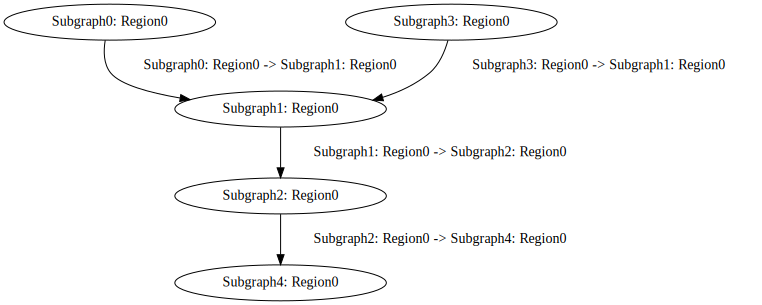

In [31]:
def show_gcs_graph(graph_of_convex_sets: GraphOfConvexSets) -> None:
    display(
        SVG(
            pydot.graph_from_dot_data(graph_of_convex_sets.GetGraphvizString())[
                0
            ].create_svg()
        )
    )

show_gcs_graph(gcs.graph_of_convex_sets())

Once you are happy with your GCS graph, run the code below to solve the GCS Trajectory Optimization problem. If it finds a path, it will visualize it in meshcat for you!


In [34]:
# Solve - use subgraphs, not individual vertices
options = GraphOfConvexSetsOptions()
options.preprocessing = True
options.max_rounded_paths = 10
options.rounding_seed = 1235

traj, result = gcs.SolvePath(source_subgraph, target_subgraph, options)

if result.is_success():
    print("Path found successfully!")
    # Visualize the trajectory
    visualizer = diagram.GetSubsystemByName("meshcat_visualizer(illustration)")
    PublishPositionTrajectory(traj, context, plant, visualizer)
    visualizer.ForcedPublish(visualizer.GetMyContextFromRoot(context))
else:
    print("No feasible path found")
    print(f"Result: {result.get_solution_result()}")

INFO:drake:Solved GCS shortest path using Clp with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Found 1 unique paths, discarded 99 duplicate paths.
INFO:drake:Finished 1 rounding solutions with Clp.


Path found successfully!


### GCS Verification 

What's the length of the trajectory you solved for using GCS when you start from the joint position corresponding to `p_Start`? Enter the value to three decimal places.

In [35]:
def gcs_verification(traj: CompositeTrajectory):
    # discretize time series
    times = np.linspace(traj.start_time(), traj.end_time(), 1000)
    positions = traj.vector_values(times)

    # add up path length of adjacent segments
    path_length = 0.0
    for i in range(1, len(times)):
        diff = positions[:, i] - positions[:, i - 1]
        path_length += np.linalg.norm(diff)

    print(f"Path length: {path_length:.4f}")


gcs_verification(traj)

Path length: 1.0344
